# Predicting the price of diamonds
## Phase 2: Statistical Modelling

#### Group Name:

#### Name(s) & ID(s) of Group Members:

#### 

## Table of Contents
- [Introduction](#intro)
- [Statistical Modelling](#sm)
- [Critique & Limitations](#cl)
- [Summary & Conclusions](#sc)

## Introduction <a id='intro'></a>

### Phase 1 Summary

A brief yet complete and accurate summary of the work conducted for your Phase 1 report and how they relate to your Phase 2 report. 

**Important Phase 2 Note:** Please do NOT include your Phase 1 report or its contents with your Phase 2 submissions. You can, however, make some changes with your Phase 1 tasks if you need to, and then ONLY include these changes with your Phase 2 report with some explanation for these changes.

**NOTE:** I (Mitchell) removed the random sampling since more data gave us better results and didn't really impact calculation times

### Report Overview

A complete and accurate overview of the contents of your Phase 2 report. Clarification: A Table of Contents is not a report overview.

### Overview of Methodology

A detailed, complete, and accurate overview of your statistical modelling methodology (which is multiple linear regression).

## Statistical Modelling <a id='sm'></a>

### Full Model Overview

Overview of full model, including the variables and terms you are using in your regression model.

Our model will predict the sale price of a diamond based on factors such as its weight (carat), cut, colour, clearness, and dimension ratio. For a full explanation of each variable, please see our Phase 1 report.

#### Module Imports

First, we import all our required libraries and load our cleaned data. We can see a sample of the data as well.

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) 

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

df = pd.read_csv('diamonds_cleaned_no_sampling.csv')
df.head()

,carat,cut,color,clarity,depth,table,price
0,0.23,Ideal,E,SI2,61.5,55.0,326
1,0.21,Premium,E,SI1,59.8,61.0,326
2,0.23,Good,E,VS1,56.9,65.0,327
3,0.29,Premium,I,VS2,62.4,58.0,334
4,0.31,Good,J,SI2,63.3,58.0,335


#### Full Model Fitting

Details of assumptions check, model selection, plots of residuals, and technical analysis of regression results.

**NOTE:** The second half of [this](https://github.com/vaksakalli/stats_tutorials/blob/master/Regression_Case_Study1_web.ipynb) regression case study ("Statistical Modeling and Performance Evaluation" Section) will be **very helpful** for this Model Fitting section.

Much of the data in our model is still categorical. We must first one-hot encode this data in order to fit it to a model effectively.

In [79]:
df_enc = pd.get_dummies(df)
df_enc.sample(10, random_state=405)

,carat,depth,table,price,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
36187,0.41,63.0,57.0,931,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
51096,0.71,62.3,63.0,2335,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2414,0.87,62.2,57.0,3180,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2136,0.71,61.8,56.1,3123,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
47156,0.45,61.8,55.0,1833,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
11719,0.34,61.4,54.0,596,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
51509,0.74,59.2,60.0,2383,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
27566,2.40,62.0,55.0,18374,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
33746,0.31,62.0,55.0,840,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
35068,0.32,61.5,56.0,886,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


Some of our column names also contain spaces. The statsmodels module does not behave well with columns with spaces, so we will remove them:

In [80]:
for col in df_enc.columns:
    col_cont = df_enc[col]
    df_enc = df_enc.drop(col, 1)
    col = col.replace(' ', '_')
    df_enc[col] = col_cont
    
df_enc.head()

,carat,depth,table,price,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very_Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


Then, we create a formula string to create our initial full model, including all our newly created one-hot encoded columns:

In [81]:
formula = 'price ~ ' + ' + '.join(df_enc.drop(columns='price').columns)
print(f'Formula string: {formula}')

Formula string: price ~ carat + depth + table + cut_Fair + cut_Good + cut_Ideal + cut_Premium + cut_Very_Good + color_D + color_E + color_F + color_G + color_H + color_I + color_J + clarity_I1 + clarity_IF + clarity_SI1 + clarity_SI2 + clarity_VS1 + clarity_VS2 + clarity_VVS1 + clarity_VVS2


Now, we can construct and fit the full model for our dataset using OLS (ordinary least squares):

In [82]:
model_full = sm.formula.ols(formula=formula, data=df_enc)
model_full_fit = model_full.fit()
print(model_full_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 2.942e+04
Date:                Fri, 22 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:25:13   Log-Likelihood:            -4.5696e+05
No. Observations:               53940   AIC:                         9.140e+05
Df Residuals:                   53919   BIC:                         9.141e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -660.5964    245.550     -2.690

#### Full Model Diagnostic Checks

We should verify that there are no violations to our assumptions for performing a multiple linear regression. These assumptions are:
* The residuals should be nearly normal
* The residuals should have a constant variability
* The residuals are independent
* Each variable should be linearly related to the outcome

To test this, we will first extract the the actual price, predicted price, and residual for each of our datapoints: 

In [83]:
residuals_full_model = pd.DataFrame({'actual': df_enc['price'], 
                        'predicted': model_full_fit.fittedvalues, 
                        'residual': model_full_fit.resid})
residuals_full_model.head(5)

,actual,predicted,residual
0,326,-1880.655358,2206.655358
1,326,-1294.390550,1620.390550
2,327,-388.723319,715.723319
3,334,-1148.056007,1482.056007
4,335,-3656.151582,3991.151582


Now, we can plot a actual vs. predicted plot:

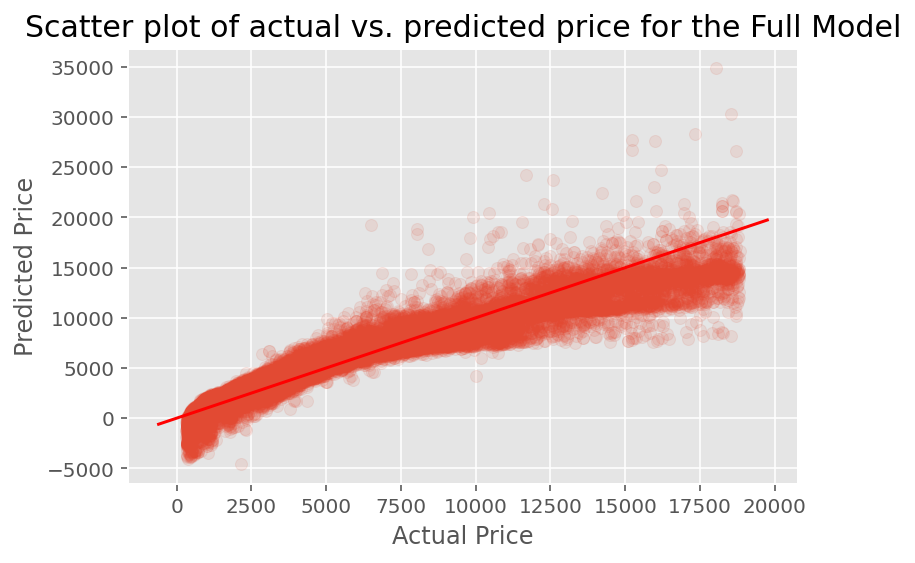

In [84]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Creating scatter plot
plt.scatter(residuals_full_model['actual'], residuals_full_model['predicted'], alpha=0.1);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Price');
plt.ylabel('Predicted Price');
plt.title('Scatter plot of actual vs. predicted price for the Full Model', fontsize=15);
plt.show();

The variability seems to be close, but not perfectly, constant. As the graph shows, the number of outliers tends to increase as the actual price increases. Let's have a look at a variance graph to determine how severe this is.

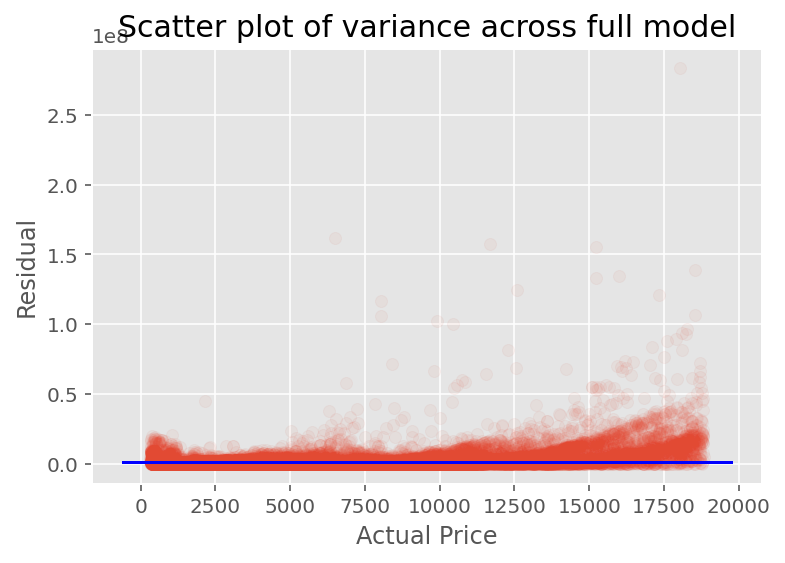

In [85]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Creating scatter plot
plt.scatter(residuals_full_model['actual'], residuals_full_model['residual']**2, alpha=0.05);
plot_line(axis=plt.gca(), slope=0, intercept=np.average(residuals_full_model['residual']**2), c="blue");
plt.xlabel('Actual Price');
plt.ylabel('Residual');
plt.title('Scatter plot of variance across full model', fontsize=15);
plt.show();

Taking the blue line as our average variance across the entire dataset, we can see that while the outliers do increase with the higher prices, Much of the variance across the data still stays within an acceptable range. We can accept this as conforming to our rules for a multiple linear regression

Let us also view the a histogram of the residuals to confirm they are nearly normal:

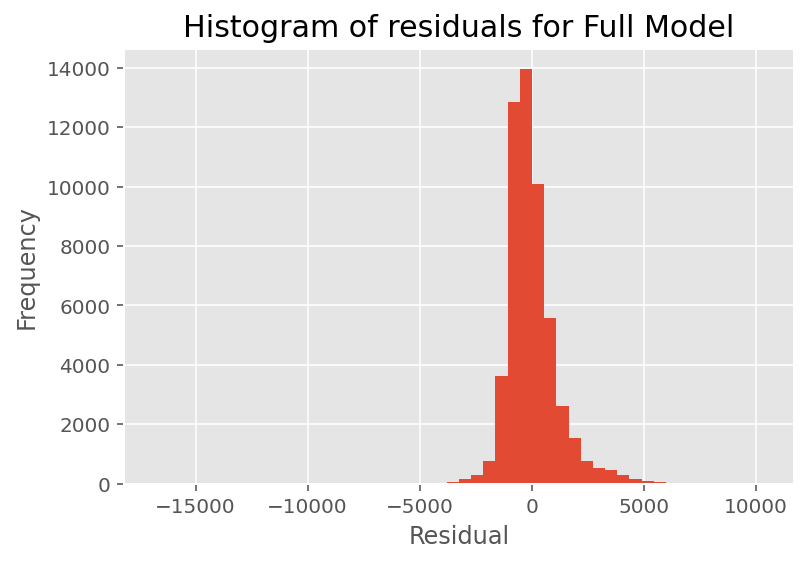

In [86]:
plt.hist(residuals_full_model['residual'], bins = 50);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Histogram of residuals for Full Model', fontsize=15);
plt.show();

The distribution of the normals appears to be slightly right skewed but mostly symmetric, and is indeed nearly normal.

### Feature Selection

Our initial R-squared value is quite high, at 0.917, explaining 91% of the variance in our model. However, we can see a few of our variables, such as cut_Very_Good, have p values that are insignificant at 0.05 level. Therefore, we will use backwards feature selection to improve our model by removing variables with the highest p-values.

We will use the preprepared code below to to perform backward feature selection using p-values ([credit](https://github.com/vaksakalli/stats_tutorials/blob/master/Regression_Case_Study1_web.ipynb)).

In [87]:
## create the patsy model description from formula
patsy_description = patsy.ModelDesc.from_formula(formula)

# initialize feature-selected fit to full model
linreg_fit = model_full_fit

# do backwards elimination using p-values
p_val_cutoff = 0.05

## WARNING 1: The code below assumes that the Intercept term is present in the model.
## WARNING 2: It will work only with main effects and two-way interactions, if any.

print('\nPerforming backwards feature selection using p-values:')

while True:

    # uncomment the line below if you would like to see the regression summary
    # in each step:
    ### print(linreg_fit.summary())

    pval_series = linreg_fit.pvalues.drop(labels='Intercept')
    pval_series = pval_series.sort_values(ascending=False)
    term = pval_series.index[0]
    pval = pval_series[0]
    if (pval < p_val_cutoff):
        break
    term_components = term.split(':')
    print(f'\nRemoving term "{term}" with p-value {pval:.4}')
    if (len(term_components) == 1): ## this is a main effect term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0])]))    
    else: ## this is an interaction term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0]), 
                                                        patsy.EvalFactor(term_components[1])]))    
        
    linreg_fit = smf.ols(formula=patsy_description, data=df_enc).fit()
    
###
## this is the clean fit after backwards elimination
model_reduced_fitted = smf.ols(formula = patsy_description, data = df_enc).fit()
###
    
#########
print("\n***")
print(model_reduced_fitted.summary())
print("***")
print(f"Regression number of terms: {len(model_reduced_fitted.model.exog_names)}")
print(f"Regression F-distribution p-value: {model_reduced_fitted.f_pvalue:.4f}")
print(f"Regression R-squared: {model_reduced_fitted.rsquared:.4f}")
print(f"Regression Adjusted R-squared: {model_reduced_fitted.rsquared_adj:.4f}")


Performing backwards feature selection using p-values:

Removing term "cut_Very_Good" with p-value 0.5231

Removing term "cut_Premium" with p-value 0.06011

***
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 3.097e+04
Date:                Fri, 22 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:25:14   Log-Likelihood:            -4.5696e+05
No. Observations:               53940   AIC:                         9.140e+05
Df Residuals:                   53920   BIC:                         9.141e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t   

####  Reduced Model Overview

Overview of your reduced model, including the variables and terms you are using in your model.

#### Reduced Model Diagnostic Checks

You need to check whether there are indications of violations of the regression assumptions for the reduced model.

In [88]:
residuals_reduced_model = pd.DataFrame({'actual': df_enc['price'], 
                        'predicted': model_reduced_fitted.fittedvalues, 
                        'residual': model_reduced_fitted.resid})
residuals_reduced_model.head(5)

,actual,predicted,residual
0,326,-1881.167250,2207.167250
1,326,-1305.751047,1631.751047
2,327,-382.686803,709.686803
3,334,-1161.750433,1495.750433
4,335,-3657.240675,3992.240675


Scatter plot of real vs. predicted

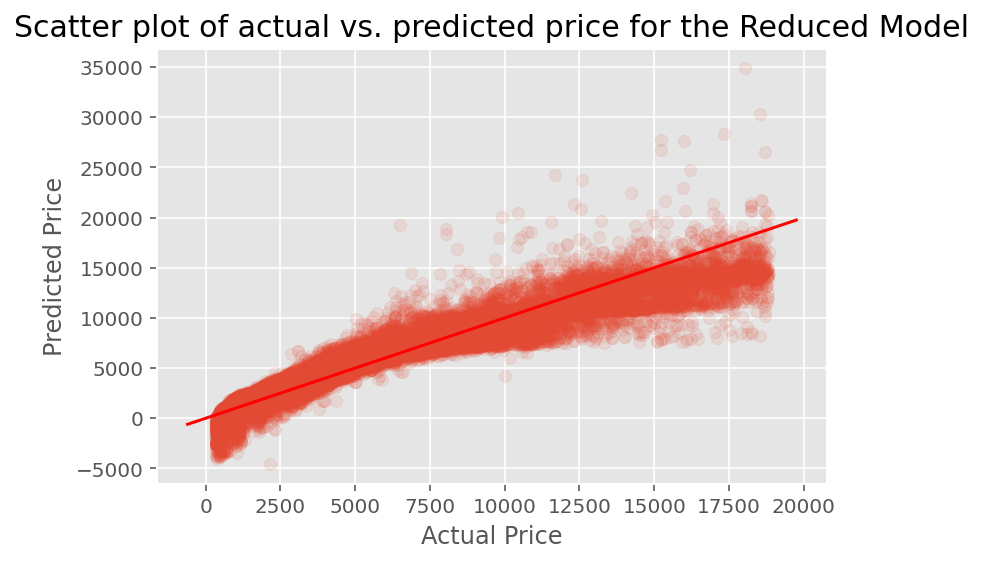

In [89]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Creating scatter plot
plt.scatter(residuals_reduced_model['actual'], residuals_reduced_model['predicted'], alpha=0.1);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Price');
plt.ylabel('Predicted Price');
plt.title('Scatter plot of actual vs. predicted price for the Reduced Model', fontsize=15);
plt.show();

Scatter plot of variance:

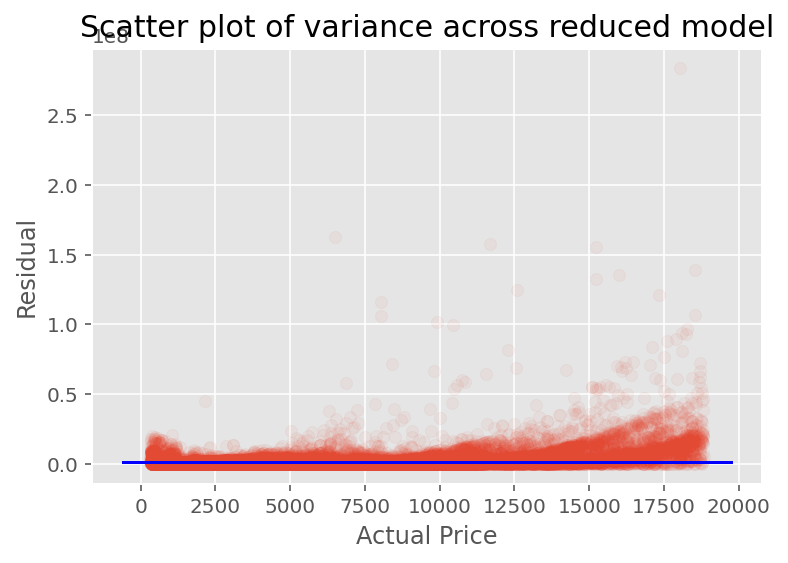

In [90]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Creating scatter plot
plt.scatter(residuals_reduced_model['actual'], residuals_reduced_model['residual']**2, alpha=0.05);
plot_line(axis=plt.gca(), slope=0, intercept=np.average(residuals_reduced_model['residual']**2), c="blue");
plt.xlabel('Actual Price');
plt.ylabel('Residual');
plt.title('Scatter plot of variance across reduced model', fontsize=15);
plt.show();

Histograms of residuals:

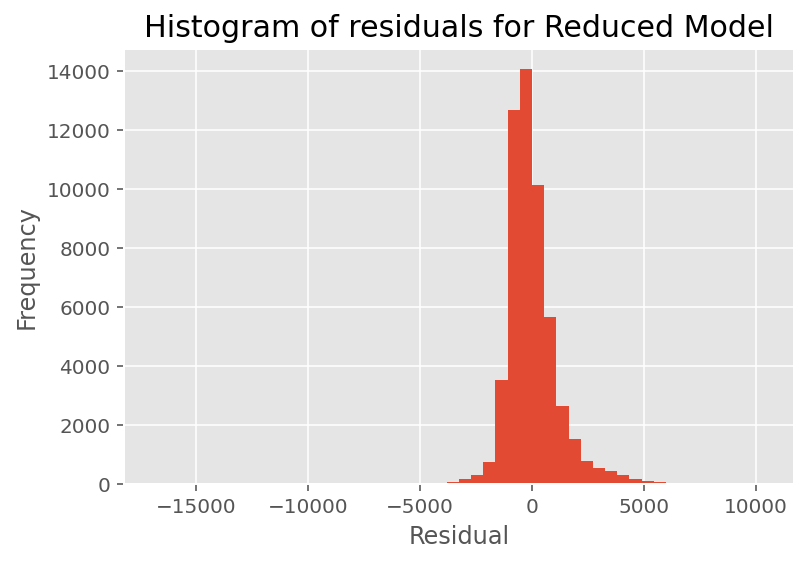

In [91]:
plt.hist(residuals_reduced_model['residual'], bins = 50);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Histogram of residuals for Reduced Model', fontsize=15);
plt.show();

## Critique & Limitations <a id='cl'></a>

Critique & Limitations of your approach: strengths and weaknesses in detail.

## Summary & Conclusions <a id='sc'></a>

### Project Summary

A comprehensive summary of your entire project (both Phase 1 and Phase 2). That is, what exactly did you do in your project? (Example: I first cleaned the data in such and such ways. And then I applied multiple linear regression techniques in such and such ways. etc).

### Summary of Findings

A comprehensive summary of your findings. That is, what exactly did you find about your particular problem?

### Conclusions

Your detailed conclusions as they relate to your goals and objectives.